# IN2110 obligatorisk innlevering 1a
**Våren 2024**

Det er en god idé å lese gjennom hele oppgavesettet før du setter i gang.
Dersom du har spørsmål så kan du:
- gå på gruppetime,
- spørre på  Discourse 
- eller sende epost til in2110-hjelp@ifi.uio.no dersom alternativene over av en eller annen grunn ikke passer for spørsmålet ditt.

## Oppsett
Når du har klonet dette github-repoet som denne notebooken ligger i, har du tilgang til datene og hjelpefilene som ligger i denne mappa. Hvis du ønsker å kopiere denne mappa, "1a", over til et annet sted, så skulle det gå bra. Bare pass på at du følger med på om det er oppdateringer her i repoet som gir ut obligen. Når du har aktivert in2110-miljøet med conda, så har du tilgang til pakkene som trengs for å kjøre denne notebooken.

## Bakgrunn
For denne innleveringen skal vi jobbe med datasettet Norwegian Review Corpus
(NoReC) som består av anmeldelser hentet fra en rekke norske nettaviser.
NoReC består av over 35.000 dokumenter fordelt på 9 tematiske kategorier. I dataene som er klargjort for oppgaven, er to av kategoriene fjernet for å spare plass. Vi skal kun se på 3 av de gjenstående kategoriene: ‘games’, ‘restaurants’ og ‘literature’. I oppgavene som følger skal vi skal jobbe med å *(i)* pre-prosessere tekstene, *(ii)* representere dem i en vektorrom-modell og så *(iii)* lage en klassifikator for å predikere hvilken kategori en gitt anmeldelse tilhører.

## Datagrunnlaget
Når vi jobber med klassifikasjon er det viktig at vi setter til side en del av
dokumentene slik at vi kan bruke disse til å evaluere klassifikatoren. NoReC er
delt i tre deler: ‘train’, ‘dev’ og ‘test’. Det er god praksis å trene med treningssettet
(‘train’), evaluere underveis med valideringssettet (‘dev’ for *development*)
og spare testsettet (‘test’) helt til slutt. Tekstene i NoReC er sortert på forhånd for å splittes i  ‘train’, ‘dev’ og ‘test’. Informasjonen om hvilken split dokumentet tilhører, ligger i metadata for hvert dokument. Slik dataene er lagret, er det en liste av dict- én for hvert dokument. Under nøkkelen "text" ligger teksten i dokumentet, og under nøkkelen "metadata" ligger en ny dict der vi kan finne kategorien til dokumentet, og hvilken split det tilhører. 


## Innleveringsformatet
Innleveringen skal helst bestå av én Jupyter notebook med både kode og tilhørende forklaringer. **La det siste du gjør før innlevering være å kjøre hele notebooken før du lagrer siste gang. Den skal kjøre uten å feile, og vise den grafikken og de utskriftene som skal være med.**
Vi understreker at innlevering av koden alene ikke er nok for å bestå oppgaven
– vi forventer at notebooken også skal inneholde beskrivelser (på norsk eller engelsk)
av hva dere har gjort og begrunnelser for valgene dere har tatt underveis. Bruk helst
hele setninger, og matematiske formler om nødvendig. La enhver oblig bli en trening i å formidle forskning. Evalueringstallene bør presenteres i tabeller. Det å forklare med egne ord (samt begreper vi har gått gjennom på
forelesningene) hva dere har implementert og reflektere over hvorvidt løsningen dere
har lagt besvarer oppgaven er en viktig del av læringsprosessen – ta det på alvor! 
Vi foretrekker som sagt at innleveringen deres kun består av én Jupyter notebook, men hvis
dere av tekniske grunner ikke klarer å besvare alle spørsmålene med Jupyter kan dere
også levere vanlige Python filer med en PDF-rapport som inneholder grafikken fra visualiseringen, og deres tekst-besvarelser.

### Tips for jobbing med notebooks
Det er en god idé å teste kode snarest mulig etter at du har lagd en ny funksjon. Lag deg gjerne ei ny celle i notebooken der du skriver ut et eksempel på dine data, og tester koden med eksempeldata som du lager deg. Slik testing er ikke en del av oppgaven, og kan slettes hvis den tar mye plass under kjøring. 

I prekoden står det `None` flere steder. Her skal din kode inn i stedet. I tillegg skal din kode inn de andre stedene der teksten sier det.

In [116]:
import json
import regex
import nltk
import nltk.data
import helpers_1a as h1a
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# NLTK-ressurser vi skal ha tilgjengelig i denne obligen
resources = {"punkt": "tokenizers/punkt"}

for name, path in resources.items():
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(name)


## Oppgave 1 Data og pre-prosessering
### a) Data
Under er det en funksjon kalt prepare_data(). Denne tar inn en iterator
over dokumenter og skal returnere to lister: en liste med dokumenttekstene og
en liste med den respektive kategorien for hvert av dokumentene.
Skriv ferdig prepare_data(). Husk at vi kun ønsker dokumentene
i kategoriene ‘games’, ‘restaurants’ og ‘literature’.


In [117]:
"""
Dette er den første koden jeg lagde:
def prepare_data(documents, split): # Oppgave 1 a
    
    categories = ['games', 'restaurants', 'literature']
    data = []
    labels = []
    for ordbok in documents:
        if ordbok['metadata']['category'] in categories and ordbok['metadata']['split'] == split:
            data.append(ordbok['text'])
            labels.append(ordbok['metadata']['category'])

    assert len(data) == len(labels)
    return data, labels

    Jeg bestemte meg derimot for å lage en klasse isteden, slik at man kan behandle hvert datasett som objekter.
"""
class Data:
    def __init__(self, documents, split):
        self._documents = documents
        self._split = split
        self._categories = ['games', 'restaurants', 'literature']
        self._data = []
        self._labels = []
        for ordbok in documents:
            if ordbok['metadata']['category'] in self._categories and ordbok['metadata']['split'] == self._split:
                self._data.append(ordbok['text'])
                self._labels.append(ordbok['metadata']['category'])

        assert len(self._data) == len(self._labels)

    def __str__(self):
        return self._split

    def hent_data(self):
        return self._data

    def hent_labels(self):
        return self._labels

    def tilfeller_av_hver_kategori(self):
        oversikt = {}
        for kategori1 in self._categories:
            matcher = 0
            for kategori2 in self._labels:
                if kategori1 == kategori2:
                    matcher += 1
            oversikt[kategori1] = matcher

        return oversikt
def tokenize(text): #Oppgave 1 b
    """Tar inn en streng med tekst og returnerer en liste med tokens."""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'["/.:,]', '', text)
    tokenized = nltk.word_tokenize(text)
    # Å splitte på mellomrom er fattigmanns tokenisering. Endre til noe bedre!

    return tokenized



In [118]:
# Prekode: Her laster vi inn dataene, etter at du har skrevet ferdig prepare_data()
datakilde = "norec_excerpts.json"
with open (datakilde, encoding = "utf-8") as rf:
    norecdata = json.load(rf)
#train_data, train_labels = prepare_data(norecdata, "train")
train_set = Data(norecdata, 'train')

# Valideringsdata
#dev_data, dev_labels = prepare_data(norecdata, "dev")
dev_set = Data(norecdata, 'dev')

# Testdata
#test_data, test_labels = prepare_data(norecdata, "test")
test_set = Data(norecdata, 'test')


## Oppgave 1
### b) Pre-prosessering
Prekoden over inneholder funksjonen tokenize() som splitter på mellomrom. Vi
ønsker en bedre tokenisering av dokumentene.
- Tokeniser treningssettet med den originale funksjonen og rapporter hvor mange tokens og hvor mange ordtyper du får.
- Endre funksjonen til å bruke en bedre tokenizer, f.eks. word_tokenize
i NLTK. Rapporter antall tokens og ordtyper for denne også.
- Prøv andre typer pre-prosessering, som f.eks. å gjøre om alle ord
til små bokstaver, normalisering av tall, eller normalisering av
tokens som betyr det samme (som f.eks. forskjellige typer hermetegn). 

Rapporter antall tokens og ordtyper for alle .
Hvilken tokenisering gir lavest antall ordtyper?


### Oppgave 1 b) Tekstbesvarelse
*Legg resultatene fra de ulike tokeniseringene inn hit, og ditt svar på hvilken tokenisering som gir lavest antall ordtyper*

Testet på første anmeldelse i datasettet:


.split(): **177 unike, 251 totalt**  
---||--- + .lower(): __171 unike, 251 totalt__
---------||-------- + re.sub(r'\d+', '', text): __--||--__  
----------------------||----------------------- + re.sub(r'["/.:,]', '', text): __167 unike, 251 totalt__  
nltk.word_tokenize: __178 unike, 278 totalt__  
--------||-------- + re.sub(r'\d+', '', text) + re.sub(r'["/.:,]', '', text): **167 unike, 251 totalt**  


## Oppgave 1 c) Statistikk
- Beregn antall dokumenter per kategori (‘games’, ‘restaurants’ og
‘literature’) i treningssettet.
- Diskuter kort fordelingen mellom kategoriene.

In [119]:
train_set.tilfeller_av_hver_kategori()


{'games': 1413, 'restaurants': 428, 'literature': 2821}

### Oppgave 1 c) Tekstbesvarelse
*Diskuter kort fordelingen mellom kategoriene:*

Det er veldig stor variasjon i mangden data for de tre kategoriene. Litteratur har omtrent dobbelt så mange tekster som Spill, som igjen har mer en trippelt så mange tekster som Restauranter. Hvis jeg skal gjette, vil jeg tro dette kan føre til at systemet i flere tilfeller kan komme til å feilklassifisere Restaurant-tekster som Litteratur- eller Spill-tekster. Mens feilklassifisering under Spill kanskje ikke er så sannsynlig, siden spillanmeldelser og retaurantanmeldelser for alt jeg veit ikke har så mye felles vokabular, er det mange kokebøker blant Litteratur-tekstene, noe som kan føre til hyppigere feilklassifisering av restaurantanmeldelser som bokanmeldelser. Da ville jeg kanskje heller sett at antallet spillanmeldelser og restaurantanmeldelser i treningssettet var omvendt.

# Oppgave 2 Dokumentrepresentasjon
Vi ønsker å representere dokumentene som vektorer, som vi så kan bruke som
input til å trene en klassifikator. Klassifikatoren lar oss predikere hvilken kategori et gitt
dokument tilhører. For å gjøre dette skal vi bruke scikit-learn. De klassene og
funksjonene dere trenger, er allerede importert i prekoden. Bruk gjerne litt tid
på å se på veiledningene på http://scikit-learn.org. I denne seksjonen skal
vi jobbe med å lese inn dokumentene og lage vektorrepresentasjoner. Så skal vi
jobbe med selve klassifikatoren i neste seksjon.

## Oppgave 2 a) Vektorisering
For å lage en tall-representasjon av dokumentene, skal vi bruke `CountVectorizer` fra scikit-learn for
å lage bag-of-words-representasjoner. Den tar inn en iterator
over dokumenter og returnerer en dokumentvektor for hvert dokument. Fordi
ordforrådet er så stort – over 500 000 ordtyper for hele NoReC – blir hver enkelt
dokumentvektor 500 000-dimensjonale hvis vi bruker alle ordene. Vi kommer til å
begrense oss til de 5000 mest frekvente ordene. Dette reduserer både minnebruk
og kjøretid.
CountVectorizer tar veldig mange argumenter, men dere kan ignorere de
fleste av dem; de eneste som er viktige for oss er lowercase, tokenizer og
max_features. Vi ønsker å bruke vår egen tokenizer, ikke den innebygde i
CountVectorizer, og vi ønsker heller ikke å la den gjøre om til lowercase –
vi kan heller gjøre om til små bokstaver i tokenize() om vi skulle ønske det.
Bruk argumentet max_features til å begrense ordforrådet. For å kunne ta i bruk
CountVectorizer må vi først identifisere ordtypene som skal inngå i ordforrådet / vokabularet til modellen. Det kan vi gjøre med metoden `fit()`. Det er
viktig at vi kun bruker trenings-settet for dette. Etter vi har identifisert vokabu-
læret kan vi anvende vektorisereren med `transform()`; dette vil altså opprette
dokumentvektorene. 

Endre prekoden under, slik at vi får: 
- instansiert en CountVectorizer med parametrene som beskrevet over
- trent vår vectorizert på våre treningsdata
- transformert både train, dev og test med vår trente vectorizer

In [120]:
# Vektorisering
vectorizer = CountVectorizer(lowercase=False, tokenizer=None, max_features=5000) # CountVectorizer med våre parametre
vectorizer.fit(train_set.hent_data()) # Tren vectorizer på våre data
train_vec = vectorizer.transform(train_set.hent_data()) # Bruk vectorizer til å transformere våre data
dev_vec = vectorizer.transform(dev_set.hent_data()) # Bruk vectorizer på våre data
test_vec  = vectorizer.transform(test_set.hent_data()) # Bruk vectorizer på våre data

## Oppgave 2 b) Visualisering
*Hvis du har eksportert notebooken til .py og kjører uten grafisk grensesnitt, vil visualiseringen lagres som en PNG-fil.*

Nå har vi vektorisert dokumentene, men vi vet ikke om disse vektor-representasjonene
er gode eller ikke. For å få litt mer innsikt skal vi visualisere vektorene i treningssettet. Vi har laget en ferdig funksjon som dere kan bruke:
```
scatter_plot(vectors, labels)
```
Hvor `vectors` er de vektoriserte dokumentene og `labels` er listen over kategorien
til hvert av dokumentene. Visualiseringen viser en prikk for hvert dokument,
med farge avhengig av hvilken kategori det tilhører. Ideelt sett skulle vi sett at
hver kategori var en helt separat klynge, men i praksis er det alltid noe overlapp
mellom kategorier.

Visualiser dokumentvektorene for treningssettet. Beskriv og diskuter hva du ser.


C:\Users\kroel\OneDrive\Dokumenter\IN2110\v24\obliger\1a\helpers_1a.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, data=labels, cmap=cmap, label=label, alpha=0.5)


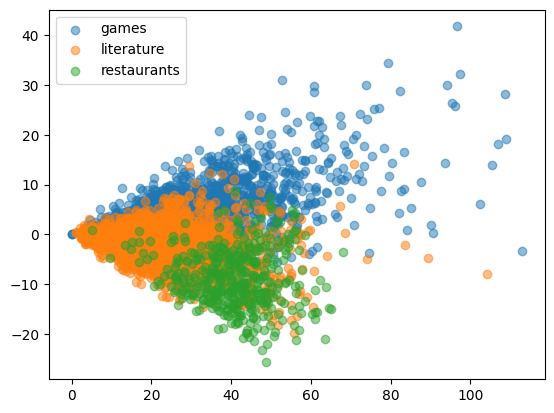

In [121]:
# Oppgave 2 b) Visualisering

h1a.scatter_plot(train_vec, train_set.hent_labels())

### Oppgave 2 b) Tekstbesvarelse
*Beskriv og diskuter hva du ser i plottet.*

Plottet viser en tydelig tredeling mellom de tre kategoriene og en ekstremt tett konsentrasjon av punkter, hvilket gjør det utfordrende å tyde hvilke punktansamlinger som eventuelt dekker for hverandre. For eksempel kan det se ut til at nærmest hele restaurant-hopen befinner seg innafor litteratur-hopens grenser, da oransje farge synes i mellomrommene mellom de grønne punktene. Dette kan henge sammen med den lave andelen restaurantanmeldelser i treningssettet og forekomsten av matrelaterte bokanmeldelser, som bemerket over. Derimot er det vanskeligere å se hvordan litteratur-hopen og spill-hopen overlapper, siden punktene her er svært fortettet og litteratur-punktene ligger lenger fram i plottet enn spill-punktene. Allikevel ser det ut til å være høy grad av overlapp her, noe som kan vekke spørsmål om klassifiseringas sannhetsverdi.

## Opppgave 2 c) Vekting
For å få bedre representasjoner kan det være lurt å vekte trekkene i ordvektorene,
slik at de trekkene som er mer informative gis høyere vekt. Vi skal se på en type
vekting kalt *term frequency–inverse document frequency (tf-idf)*. Scikit-learn
har en innebygd klasse for tf-idf kalt `TfidfTransformer` som vi skal bruke.
Den tar dokumentvektorer som input og gir ut nye vektorer som output. I
likhet med CountVectorizer må denne tilpasses treningssettet med fit() eller
fit_transform() før vi kan ta den i bruk (fordi vi først må gjøre de nødvendige
frekvenstellingene i korpuset).
- Lag en tf-idf-vektet representasjon av dokumentene
- Visualiser treningsvektorene som er vektet med tf-idf. Ser du
noen forskjell mellom vektorene med og uten tf-idf?

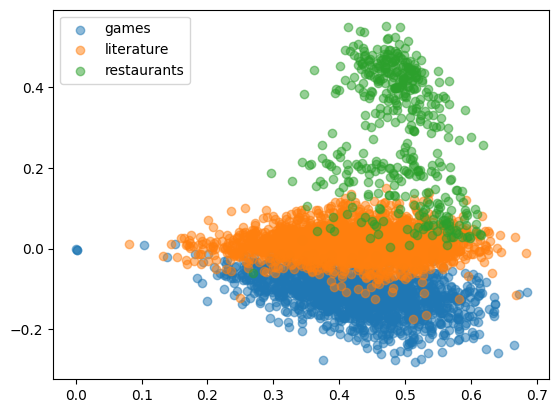

In [122]:
## Opppgave 2 c) Vekting, din kode:
tfifdf_transformer = TfidfTransformer() # Instans av TfidfTransformer
tfifdf_transformer.fit(train_vec) # Tren instansen på våre data
train_vec_tfidf = tfifdf_transformer.transform(train_vec) # Treningsdata tf-idf-transformert
dev_vec_tfidf = tfifdf_transformer.transform(dev_vec) # Dev-data tf-idf-transformert
test_vec_tfidf = tfifdf_transformer.transform(test_vec) # Testdata tf-idf-transformert

# Din kode for å visualisere tf-idf-transformerte treningsdata:
h1a.scatter_plot(train_vec_tfidf, train_set.hent_labels())

### Oppgave 2 c) Tekstbesvarelse
*Ser du noen forskjell mellom vektorene med og uten tf-idf?*

Definitivt! Hopene er nå ikke like komprimerte lenger, og det er enklere å tyde skillene mellom dem. Det kan nå også se ut til at Litteratur- og Spill-hopene ikke overlapper hverandre i så stor grad (dette var umulig å tyde ut fra forrige plott uten tf-idf-vekting), da det synes å være hvitt mellom punktene ved (0.25, 0.0) og (0.55, -0.1) i skillet mellom blå og oransje hop. Den lange "komethalen" med spredte blå punkter fra forrige plott er også borte, mens Restaurant-vektorene er mer spredt igjen. Aller mest interessant er kanskje det tydelige skillet mellom Restaurant-punktene (én tettere ansamling i toppen og et bredere, mer spredt parti under, skilt av en relativt punktfattig sone). Dette gir desto mer grobunn for hypotesen om kulinarisk litteratur; den øvre hopen kan tenkes å være utvilsomme restaurantanmeldelser, mens det nedre adskilte sjiktet kan være mer eller mindre vanskelig klassifiserbare restaurant-/bokanmeldelser. Verdt å notere seg er også at klassedistribusjonen er snudd på hodet (grønn øverst, blå nederst).

# Oppgave 3: Klassifisering
Vi skal bruke k-NN for å predikere hvilken kategori dokumentene i valideringssettet og testsettet tilhører ved hjelp av `KNeighborsClassifier` fra scikit-learn.
Klassifikatoren trenes med fit() på treningsdataene og kan brukes for å predikere med predict() på testdata. For best resultat er det viktig at trenings- og
testdataene er pre-prosessert på samme måte. F.eks. vil en klassifikator trent
uten tf-idf gi dårlige resultater for dokumentvektorer med tf-idf. 
#### Hyper-parameter tuning
Ved å endre på verdien av k kan man tilpasse klassifikatoren. Avhengig av datasett, preprosessering og vekting vil forskjellige verdier av k kunne gi forskjeller i ytelse. *K* er en hyperparameter i dette maskinlæringsprosjektet, og vi skal øve på å finne beste hyperparameter, ved å prøve en rekke alternativer for å se hva som gir best resultat. Det er her dev-settet kommer inn som et midlertidig testsett mens vi utvikler beste modell. Siden vi definerer "beste modell" som den som gjør det best på dev-settet, er det viktig at vi sparer det endelige testsettet til slutt, slik at vi ser hvordan modellen fungerer på data som vi ikke har brukt på noe trinn i utviklingen av modellen.

### a) k-NN
Lag en instans av KNeighborsClassifier der k = 3. Tren denne på treningsdata, og test på dev-data ved hjelp av accuracy_score

### b) Evaluering
Et vanlig brukt mål får å evaluere en klassifikator er accuracy. Vi kan beregne
dette ved hjelp av funksjonen `accuracy_score()` fra scikit-learn. Den tar to
argumenter: en liste med sanne merkelapper og en med predikerte merkelapper.
De sanne merkelappene er listen over kategorier for hvert dokument som vi
fikk fra NoReC (altså såkalte ‘gull-standard’ merkelapper), mens de predikerte
er modellens egne som vi får fra predict(). 

**Hyper-parameter tuning:** 
Lag ei sløyfe som trener en klassifikator for forskjellige verdier av k med og uten tf-idf, 
og beregn accuracy for hver av dem. Du kan f.eks. teste med k fra 1 til 20. 
- Inkluder en tabell med resultatene i rapporten.
- Diskuter resultatene dine. Hvilken kombinasjon av vekting og k-
verdi gir best accuracy?

In [123]:
# Oppgave 3 a) Din koding:

# Lag en instans av KNeighborsClassifier der k = 3:
knn_clf = KNeighborsClassifier(n_neighbors=3)

# Tren denne på treningsdata:
knn_clf.fit(train_vec, train_set.hent_labels())

# Test klassifikatoren ved hjelp av accuracy_score():
accuracy_score(dev_set.hent_labels(), knn_clf.predict(dev_vec))
accuracy_score(dev_set.hent_labels(), knn_clf.predict(dev_vec_tfidf))

0.3024054982817869

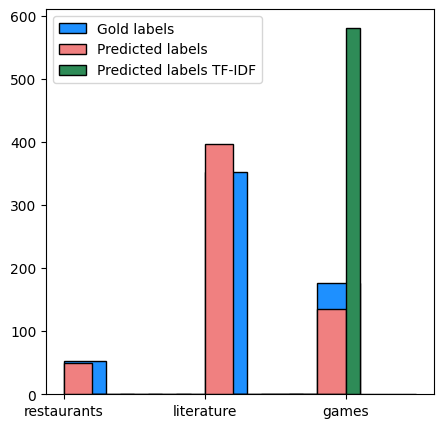

In [124]:
plt.figure(figsize=(5, 5))
plt.hist(dev_set.hent_labels(), width=0.3, label='Gold labels', color='dodgerblue', edgecolor='black')
plt.hist(knn_clf.predict(dev_vec), label='Predicted labels', width=0.2, color='lightcoral', edgecolor='black')
plt.hist(knn_clf.predict(dev_vec_tfidf), label='Predicted labels TF-IDF', width=0.1, color='seagreen', edgecolor='black')
plt.legend(loc='upper left')


In [125]:
# Oppgave 3 b) Din koding:
"""Lag ei sløyfe som trener en klassifikator for forskjellige verdier av k med og uten tf-
idf, og beregn accuracy for hver av dem:"""

"""---------ADVARSEL----------
DENNE KODEN TAR EVIGHETER Å KJØRE
"""

highest_accuracy = 0
for k in range(1, 21):
    if k==5 or k==10 or k==15 or k==20:
        print('-----', k, '-----')
        
    knn_clf = KNeighborsClassifier(n_neighbors=k)

    knn_clf.fit(train_vec, train_set.hent_labels())

    vectors = [dev_vec, dev_vec_tfidf]
    for i in range(2):
        score = accuracy_score(dev_set.hent_labels(), knn_clf.predict(vectors[i]))
            
        if highest_accuracy < score and i == 1:
            highest_accuracy = score
            print('Nøyaktighet: ', score, 'k =', k, 'TF-IDF', 'Trent: Ingen vekting')
        elif highest_accuracy < score:
            highest_accuracy = score
            print('Nøyaktighet: ', score, 'k =', k, 'Ingen vekting', 'Trent: Ingen vekting')

    knn_clf.fit(train_vec_tfidf, train_set.hent_labels())

    for i in range(2):
        score = accuracy_score(dev_set.hent_labels(), knn_clf.predict(vectors[i]))
            
        if highest_accuracy < score and i == 1:
            highest_accuracy = score
            print('Nøyaktighet: ', score, 'k =', k, 'TF-IDF', 'Trent: TF-IDF')
        elif highest_accuracy < score:
            highest_accuracy = score
            print('Nøyaktighet: ', score, 'k =', k, 'Ingen vekting', 'Trent: TF-IDF')
    

Nøyaktighet:  0.8591065292096219 k = 1 Ingen vekting Trent: Ingen vekting
Nøyaktighet:  0.936426116838488 k = 1 Ingen vekting Trent: TF-IDF
Nøyaktighet:  0.9432989690721649 k = 3 Ingen vekting Trent: TF-IDF
Nøyaktighet:  0.9639175257731959 k = 3 TF-IDF Trent: TF-IDF
----- 5 -----
Nøyaktighet:  0.9810996563573883 k = 5 TF-IDF Trent: TF-IDF
Nøyaktighet:  0.9828178694158075 k = 7 TF-IDF Trent: TF-IDF
Nøyaktighet:  0.9845360824742269 k = 9 TF-IDF Trent: TF-IDF
----- 10 -----
----- 15 -----


### Oppgave 3b Tekstbesvarelse
- Inkluder en tabell med resultatene i rapporten.

Output:
Nøyaktighet:  0.8591065292096219 k = 1 Ingen vekting Trent: Ingen vekting
Nøyaktighet:  0.936426116838488 k = 1 Ingen vekting Trent: TF-IDF
Nøyaktighet:  0.9432989690721649 k = 3 Ingen vekting Trent: TF-IDF
Nøyaktighet:  0.9639175257731959 k = 3 TF-IDF Trent: TF-IDF
----- 5 -----
Nøyaktighet:  0.9810996563573883 k = 5 TF-IDF Trent: TF-IDF
Nøyaktighet:  0.9828178694158075 k = 7 TF-IDF Trent: TF-IDF
Nøyaktighet:  0.9845360824742269 k = 9 TF-IDF Trent: TF-IDF
----- 10 -----
----- ----

  F
  
- Diskuter resultatene dine. Hvilken kombinasjon av vekting og k-verdi gir best accEtter en veldig lang gjennomkjøring av koden over, ser det ut til at en TF-IDF-trent kNN-modell anvendt på uracy?

  

## Oppgave 3 c) Testing
Vi har tilpasset parameterene til klassifikatoren vår til valideringssettet og nå
ønsker vi å gjøre en siste evaluering på testsettet. For å få mest mulig realistiske
og representative resultater er det viktig at vi venter med dette helt til slutt,
slik at vi ikke tilpasser klassifikatoren testsettet. Fordi vi vil teste hvor bra
klassifikatoren vår kan generalisere til nye data, må vi være nøye på at det
reserverte testsettet er nettopp dette – nye data som ikke har påvirket de valgene
vi har tatt for klassifikatoren vår.

- Tren en klassifikator med samme valg for k-verdi og vekting (tf-idf
eller ikke) som den med høyest accuracy i forrige deloppgave.
- Test på tilsvarende representasjon av test-settet
- Hvordan er ytelsen på testsettet sammenlignet med valideringssettet?

In [127]:
# Din kode for trening av modell med beste parametre, og teste på test-settet

knn_clf = KNeighborsClassifier(n_neighbors=9)

knn_clf.fit(train_vec_tfidf, train_set.hent_labels())

accuracy_score(test_set.hent_labels(), knn_clf.predict(test_vec_tfidf))

0.9896729776247849

### Oppgave 3c Tekstbesvarelse
*Hvordan er ytelsen på testsettet sammenlignet med valideringssettet?*

Ytelsen på testsettet er betydelig bedre enn den beste ytelsen på valideringssettet, på tross av at denne i utgangspunktet var veldig god. Vi har nå en ytelse på 98.97%, som jeg vil anse som svært høyt. Kjøringa av programmet tar derimot lang tid (opp imot 5 min), noe jeg ikke er helt sikker på hva betyr.